In [1]:
import sys

print('--sys.version—')
print(sys.version)

--sys.version—
3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np

In [3]:
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),# image file을 tensocr로 변환
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=4, 
                                        shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(torch.cuda.is_available())

True


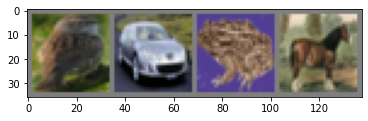

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [7]:
print(type(images), images.shape)
print(type(labels), labels.shape,labels)

<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([4]) tensor([2, 1, 6, 7])


In [9]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim,n_layer, act):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        
        self.fc = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()
        
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim,self.hid_dim))
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self,x):
        x = self.act(self.fc(x))
        for fc in self.linears:
            x = self.act(fc(x))
        x = self.fc2(x)
        return x

In [10]:
print(torch.cuda_version)

11.1


In [11]:
model = MLP(3072, 10, 100, 4, 'relu')
print(model)

MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [12]:
model = MLP(3072, 10, 100, 4, 'relu')
model.cuda()
print(model)

MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [20]:
def experiment(args):
    model = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
    model.cuda()
    print(model)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = args.lr, momentum = args.mm)
    
    for epoch in range(args.epoch):
        
        # =========Train==========#
        
        model.train()
        running_loss = 0.0
        train_loss = 0.0
        
        for i,data in enumerate(trainloader, 0):
            optimizer.zero_grad()
            
            inputs, labels = data
            inputs = inputs.view(-1, 3072)
            
            inputs = inputs.cuda()
            labels = labels.cuda()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            train_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
                
        # ===== Val =======#
        
        model.eval()
        
        correct = 0
        total = 0
        val_loss = 0
        
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images = images.view(-1, 3072)

                images = images.cuda()
                labels = labels.cuda()

                outputs = model(images)
                print(outputs)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
            val_loss = val_loss / len(valloader)
            val_acc = 100 * correct / total
            
        print('Epoch {}, Train Loss: {}, Val Loss: {}, Val Acc: {}'.format(epoch, train_loss, val_loss, val_acc ))
        
        
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
            
    return train_loss, val_loss, val_acc, test_acc

In [ ]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")


args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

args.lr = 0.001
args.mm = 0.9
args.epoch = 2


list_var1 = [4, 5, 6]
list_var2 = [50, 100, 150]

for var1 in list_var1:
    for var2 in list_var2:
        args.n_layer = var1
        args.hid_dim = var2
        result = experiment(args)
        print(result)

C:\Users\chanyoung\anaconda3\envs\pytorch\lib\site-packages\torch\cuda\__init__.py:104: UserWarning: 
NVIDIA GeForce RTX 3090 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the NVIDIA GeForce RTX 3090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))
